# Compound  size distributions

Inspect size (_i.e._ AMW and NAT) distributions for compounds Human targets. 

Note that 'compound' is defined in terms of USMILES.

In [1]:
from math import ceil

import seaborn as sns

### Configuration

In [2]:
sns.set()

In [3]:
# ChEMBL connection...

engine = create_engine(open('database.txt').read().strip())

In [4]:
min_active = 30

### Get data

Get distinct active parent compounds (with their AMWs and heavy atom counts) for Human targets. 

In [5]:
df = pd.read_sql_query("""
select distinct
      a.symbol
    , b.usmiles
    , b.amw
    , b.nat
from
  tt_curve_data_v1 a
  join tt_structure_lookup b on a.parent_cmpd_chemblid = b.cmpd
where
    a.species = 'Human'
and a.active = 1
and a.exclude = 0
order by
    a.symbol
""", engine)

df.shape

(169808, 4)

In [6]:
df.head()

symbol                                               usmiles     amw  nat
0  ABCB1  C=CC(C)(C)c1c(O)cc(O)c2c(=O)c(O)c(-c3ccc(OC)cc3)oc12  368.38   27
1  ABCB1      C=CC(C)(C)c1c(O)cc(O)c2c(=O)c(O)c(-c3ccccc3)oc12  338.35   25
2  ABCB1      C=CC(C)(C)c1c(O)cc(O)c2c(=O)cc(-c3ccc(O)cc3)oc12  338.35   25
3  ABCB1         C=CC(C)(C)c1c(O)cc(O)c2c(=O)cc(-c3ccccc3)oc12  322.35   24
4  ABCB1    C=CC(C)(C)c1c(OC)cc(O)c2c(=O)c(OC)c(-c3ccccc3)oc12  366.41   27

In [7]:
# Reformat data...

data = []

df.set_index('symbol', inplace=True)

for symbol in df.index.drop_duplicates().tolist():
    
    tmp = df.loc[symbol]
    
    n_active = tmp.shape[0]
    
    if  n_active < min_active:
        
        logging.info("Skipping '{}' (only {} actives)".format(symbol, n_active))
        
        continue
        
    amw = tmp['amw'].tolist()
    
    if type(amw) == list and len(amw) > 0: data.append((symbol, amw, tmp['nat'].tolist()))
        
df.reset_index(inplace=True)
        
len(data)

[2015/Aug/13 10:56:19 INFO    ] Skipping 'ABCB11' (only 3 actives)
[2015/Aug/13 10:56:19 INFO    ] Skipping 'ABCC2' (only 7 actives)
[2015/Aug/13 10:56:19 INFO    ] Skipping 'ABCC3' (only 3 actives)
[2015/Aug/13 10:56:19 INFO    ] Skipping 'ABCC4' (only 8 actives)
[2015/Aug/13 10:56:19 INFO    ] Skipping 'ADCY5' (only 19 actives)
[2015/Aug/13 10:56:19 INFO    ] Skipping 'APLNR' (only 15 actives)
[2015/Aug/13 10:56:19 INFO    ] Skipping 'CALCR' (only 3 actives)
[2015/Aug/13 10:56:19 INFO    ] Skipping 'CYP2E1' (only 21 actives)
[2015/Aug/13 10:56:19 INFO    ] Skipping 'CYP3A5' (only 12 actives)
[2015/Aug/13 10:56:19 INFO    ] Skipping 'DMPK' (only 25 actives)
[2015/Aug/13 10:56:19 INFO    ] Skipping 'DPYD' (only 6 actives)
[2015/Aug/13 10:56:19 INFO    ] Skipping 'GSTM1' (only 3 actives)
[2015/Aug/13 10:56:19 INFO    ] Skipping 'HCN2' (only 3 actives)
[2015/Aug/13 10:56:19 INFO    ] Skipping 'HCN4' (only 21 actives)
[2015/Aug/13 10:56:19 INFO    ] Skipping 'HNF4A' (only 7 actives)
[2015

143

### Plot AMW distributions

Recall that all parent compound with AMW > 1000 have already been excluded (see [tt_curve_data_v1](SQL/tt_curve_data_v1.sql)).

In [8]:
ncols = 4

n_plots = len(data)

nrows = int(ceil(n_plots/ncols))

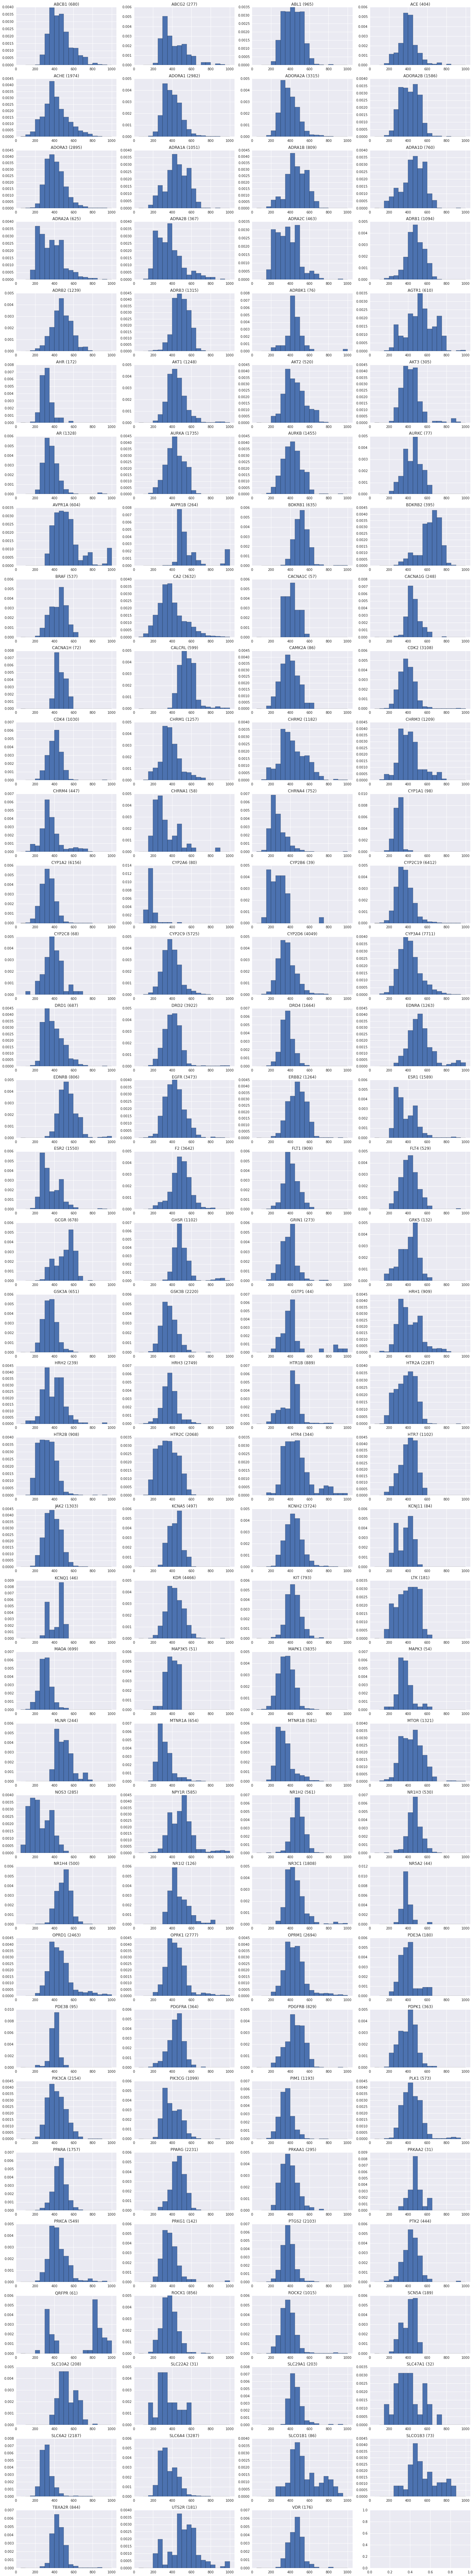

In [9]:
xsize = 50

xmax = int(ceil(df['amw'].max()/xsize)*xsize)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols)

axes = axes.flat

fig.set_size_inches(5*ncols, 3*nrows)

for n, (symbol, x, _) in enumerate(data):
    
    ax = axes[n]
    
    ax.hist(x, bins=range(xsize, xmax + xsize, xsize), normed=1, histtype='bar')
    
    ax.set_xlim(0, xmax + xsize)
    
    ax.set_title("{} ({})".format(symbol, len(x)))
    
plt.tight_layout()

plt.show()

### Relationship between AMW and NAT

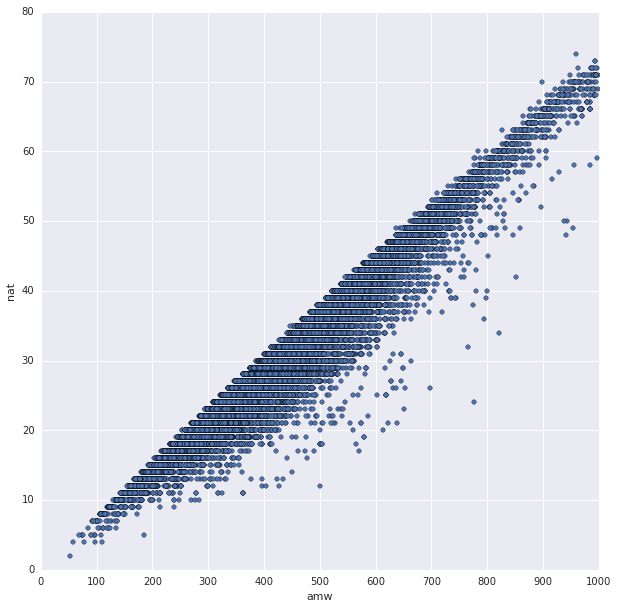

In [10]:
_ = df[['usmiles', 'nat', 'amw']].drop_duplicates().plot(x='amw', y='nat', kind='scatter', figsize=(10, 10), xlim=(0, 1000), xticks=range(0, 1001, 100), ylim=(0, 80), yticks=range(0, 81, 10))

All compounds with AMW < 500 have NAT < 40.

Thus, using a threshold of NAT <= 40 would included 'normal' compounds up to AMW 500 plus analogues with heavier elements.

### Plot NAT distributions

Recall that all parent compound with AMW > 1000 have already been excluded (see [tt_curve_data_v1](SQL/tt_curve_data_v1.sql)).

This means the maximum NAT is below 80, as is clear from the plot above.

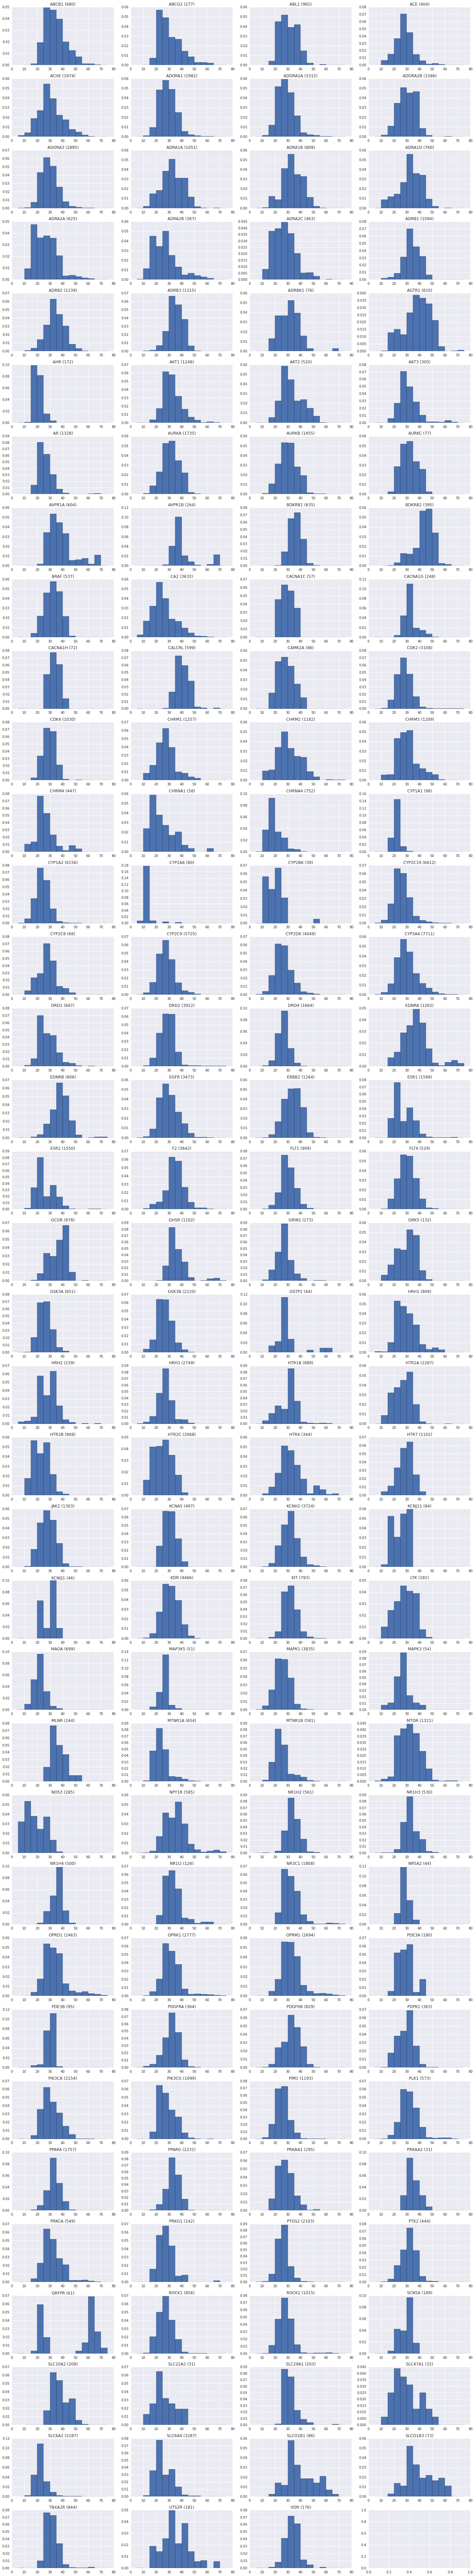

In [11]:
xsize = 5

xmax = int(ceil(df['nat'].max()/xsize)*xsize)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols)

axes = axes.flat

fig.set_size_inches(5*ncols, 3*nrows)

for n, (symbol, _, x) in enumerate(data):
    
    ax = axes[n]
    
    ax.hist(x, bins=range(xsize, xmax + xsize, xsize), normed=1, histtype='bar')
    
    ax.set_xlim(0, xmax + xsize)
    
    ax.set_title("{} ({})".format(symbol, len(x)))
    
plt.tight_layout()

plt.show()

### Effects of size thresholds

In [12]:
def heavy(df, max_nat):
    
    def f(group, max_nat):

        n_heavy, n_total = group.query('nat > @max_nat').shape[0], group.shape[0]

        return pd.Series({'n_heavy': n_heavy, 'n_ok': n_total - n_heavy, 'n_total': n_total, 'pct_heavy': round(100*n_heavy/n_total, 1)}, index=['n_heavy', 'n_ok', 'n_total', 'pct_heavy'])
    
    return df.groupby('symbol').apply(f, max_nat=max_nat).reset_index().sort(['pct_heavy', 'symbol'], ascending=[0, 1]).reset_index(drop=True)

In [13]:
df.head()

symbol                                               usmiles     amw  nat
0  ABCB1  C=CC(C)(C)c1c(O)cc(O)c2c(=O)c(O)c(-c3ccc(OC)cc3)oc12  368.38   27
1  ABCB1      C=CC(C)(C)c1c(O)cc(O)c2c(=O)c(O)c(-c3ccccc3)oc12  338.35   25
2  ABCB1      C=CC(C)(C)c1c(O)cc(O)c2c(=O)cc(-c3ccc(O)cc3)oc12  338.35   25
3  ABCB1         C=CC(C)(C)c1c(O)cc(O)c2c(=O)cc(-c3ccccc3)oc12  322.35   24
4  ABCB1    C=CC(C)(C)c1c(OC)cc(O)c2c(=O)c(OC)c(-c3ccccc3)oc12  366.41   27

In [14]:
heavy(df, max_nat=40).head(20).query("n_total > 20")

symbol  n_heavy  n_ok  n_total  pct_heavy
2    BDKRB2      293   102      395       74.2
3     QRFPR       36    25       61       59.0
6    CALCRL      266   333      599       44.4
7     AGTR1      260   350      610       42.6
8   SLCO1B3       31    42       73       42.5
10  SLCO1B1       33    53       86       38.4
12    EDNRB      264   542      806       32.8
13     GCGR      218   460      678       32.2
14    UTS2R       55   126      181       30.4
15  SLC10A2       63   145      208       30.3
16   AVPR1A      175   429      604       29.0
17    EDNRA      361   902     1263       28.6
18   AVPR1B       71   193      264       26.9
19     MLNR       52   192      244       21.3

In [15]:
heavy(df, max_nat=50).head(20).query("n_total > 20")

symbol  n_heavy  n_ok  n_total  pct_heavy
1     QRFPR       36    25       61       59.0
3   SLCO1B3       15    58       73       20.5
4   SLCO1B1       17    69       86       19.8
7    AVPR1B       36   228      264       13.6
8    BDKRB2       52   343      395       13.2
9    AVPR1A       79   525      604       13.1
10    AGTR1       58   552      610        9.5
11    GSTP1        4    40       44        9.1
12    UTS2R       14   167      181        7.7
13     HTR4       25   319      344        7.3
14    EDNRA       85  1178     1263        6.7
15    OPRD1      156  2307     2463        6.3
17    NPY1R       30   555      585        5.1
18     GHSR       47  1055     1102        4.3
19    OPRM1      112  2582     2694        4.2

In [16]:
# Show sample of input dataframe with molecules added

def show_sample(df):
    
    sample = df.loc[np.random.choice(df.index, size=min(df.index.size, 50), replace=False)]

    PandasTools.AddMoleculeColumnToFrame(sample, smilesCol='usmiles', molCol='mol')

    sample.drop('usmiles', axis=1, inplace=True)

    return sample

symbol     amw  nat                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
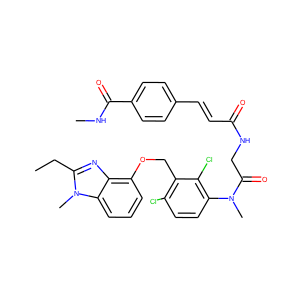
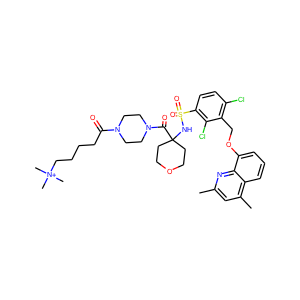
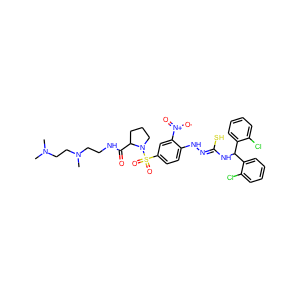
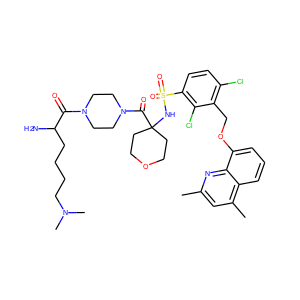
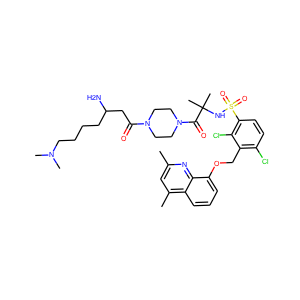
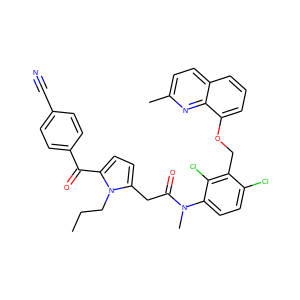
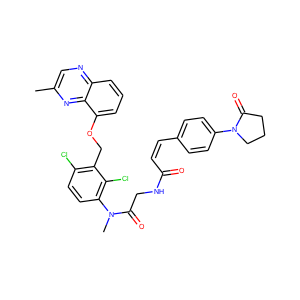
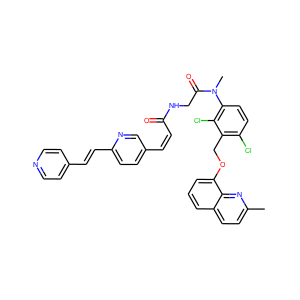
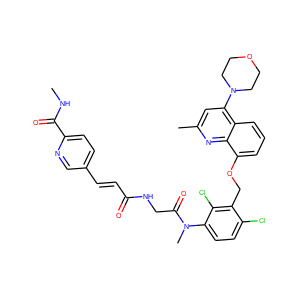
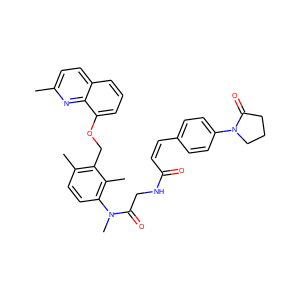
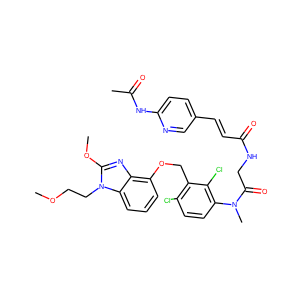
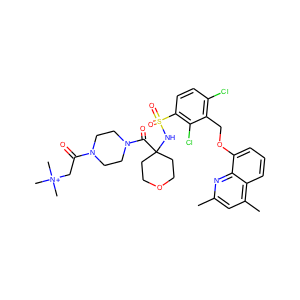
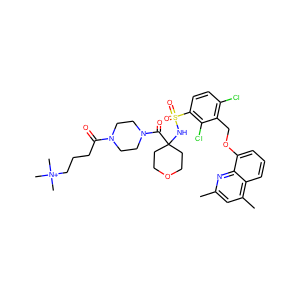
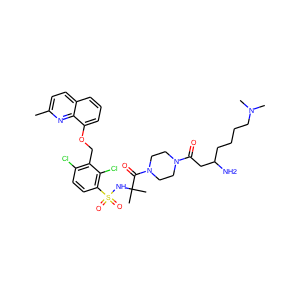
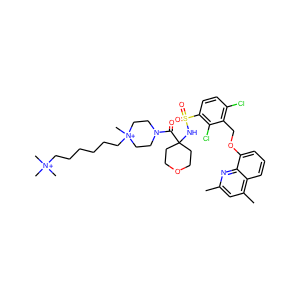
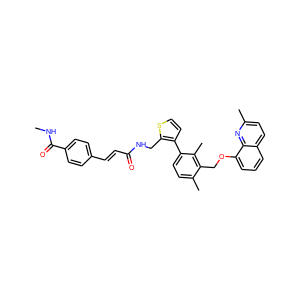
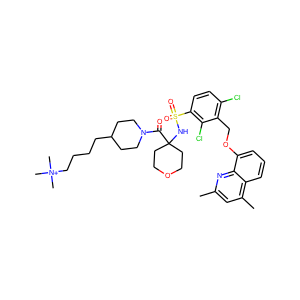
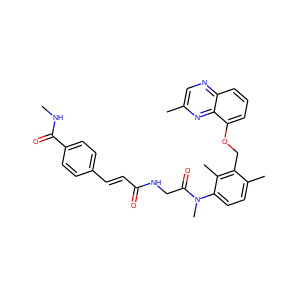
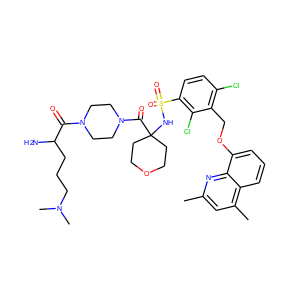
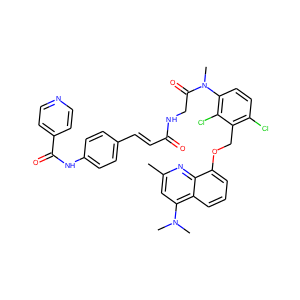
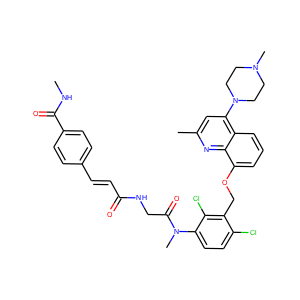
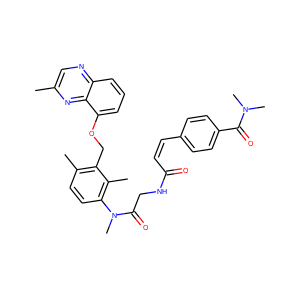
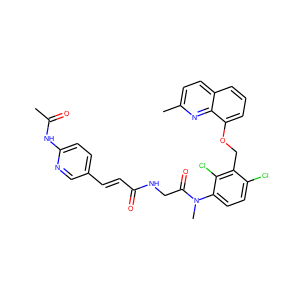
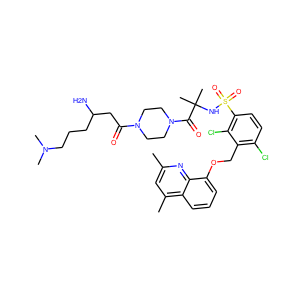
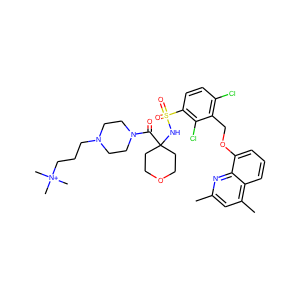
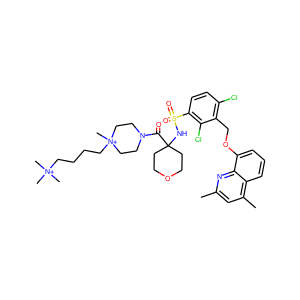
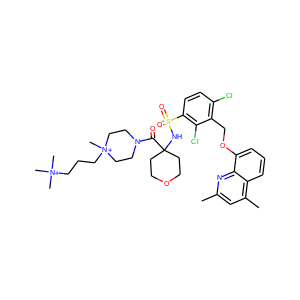
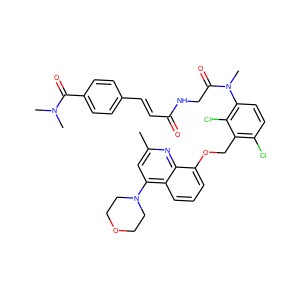
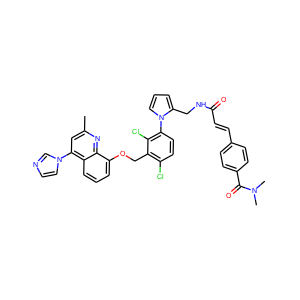
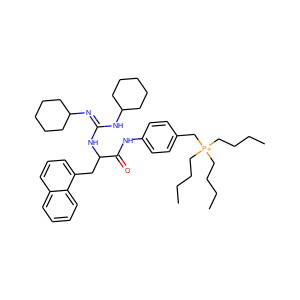
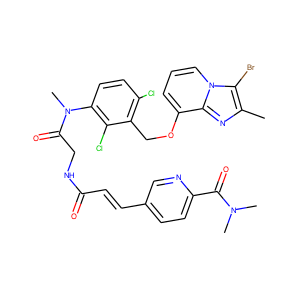
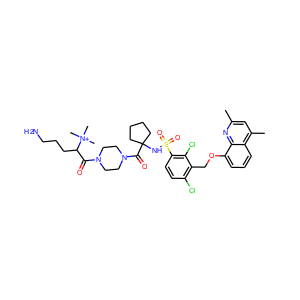
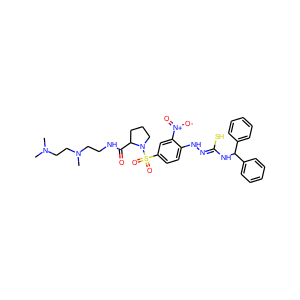
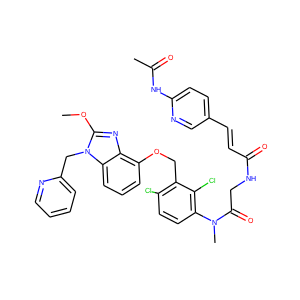
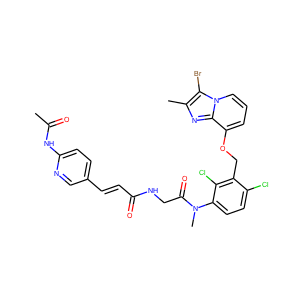
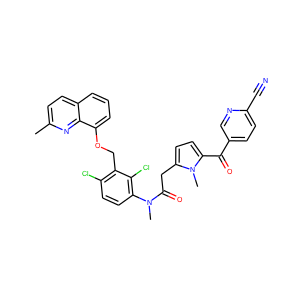
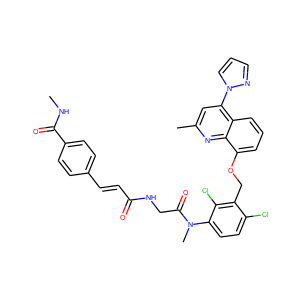
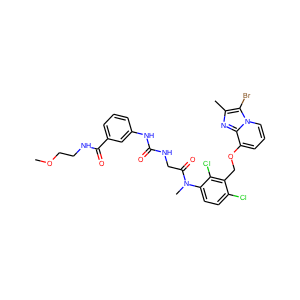
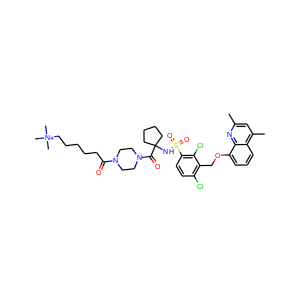
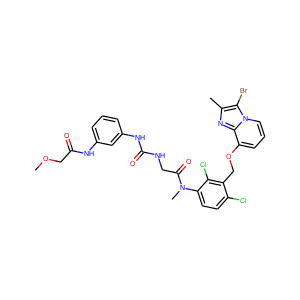
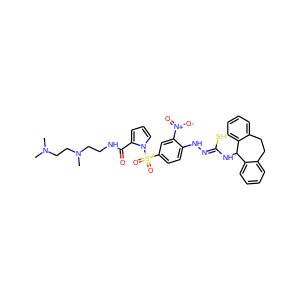
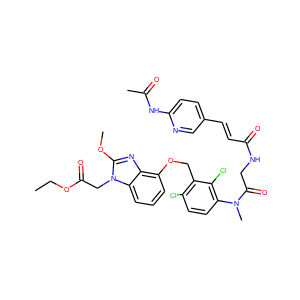
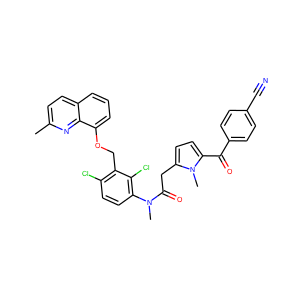
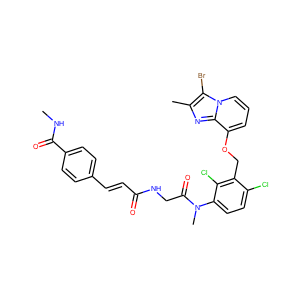
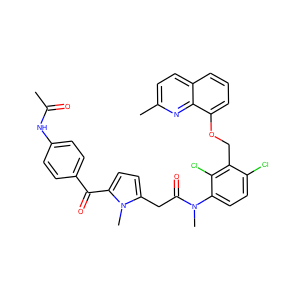
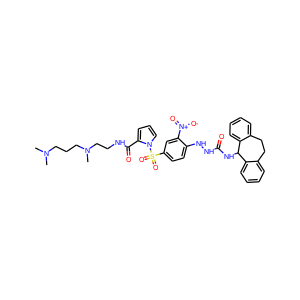
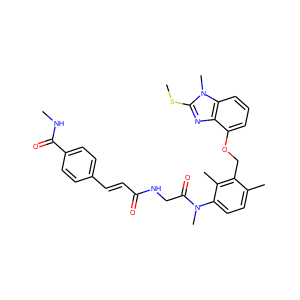
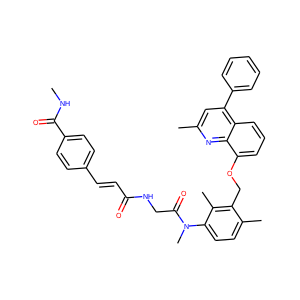
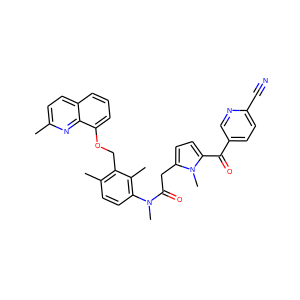
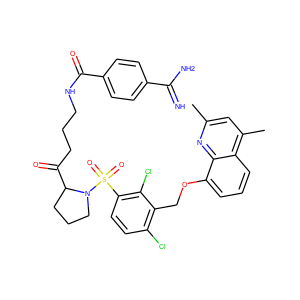

In [17]:
show_sample(df.query("symbol == 'BDKRB2' and nat > 40"))

symbol     amw  nat                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
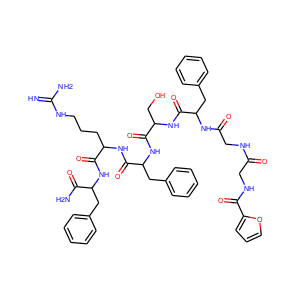
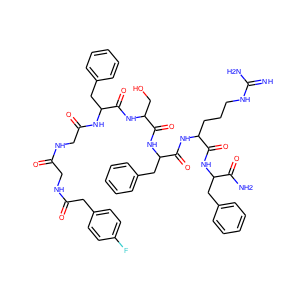
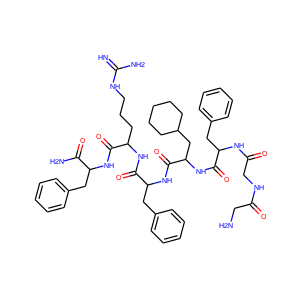
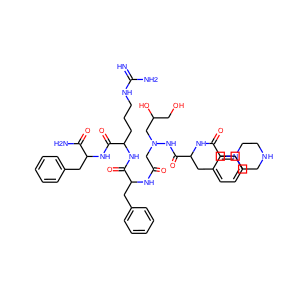
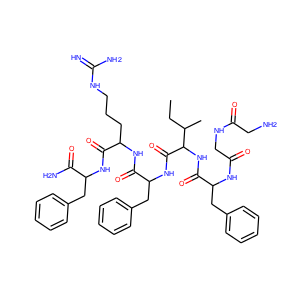
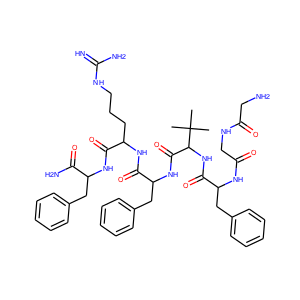
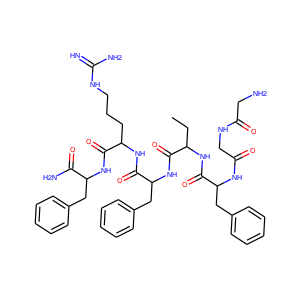
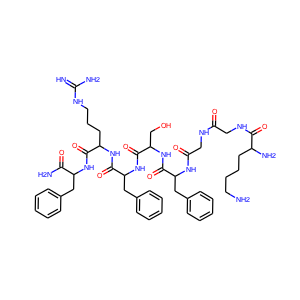
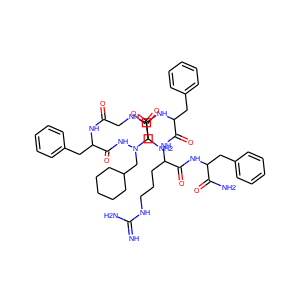
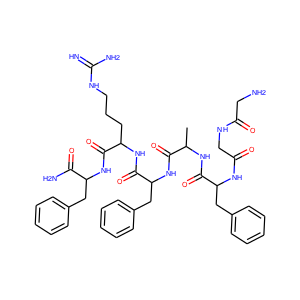
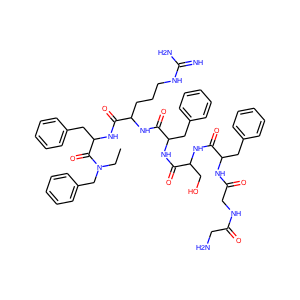
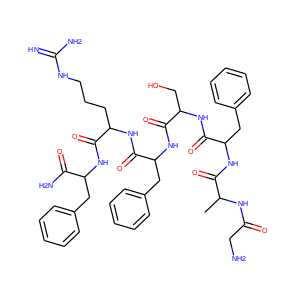
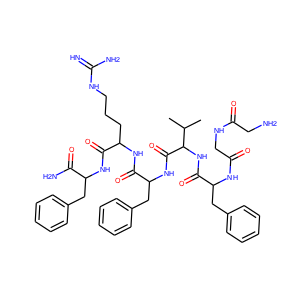
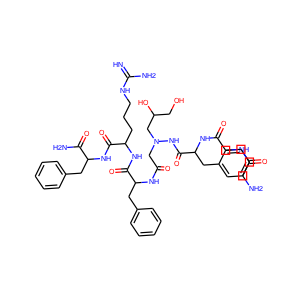
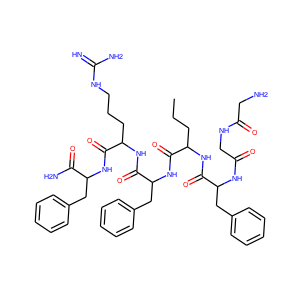
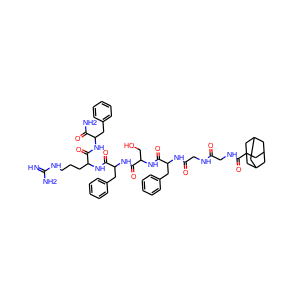
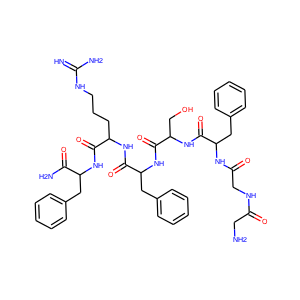
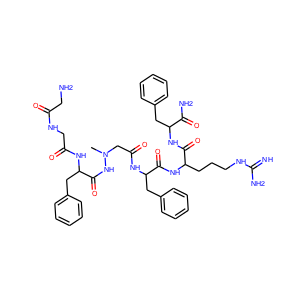
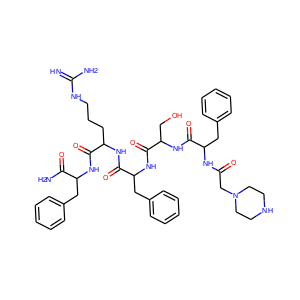
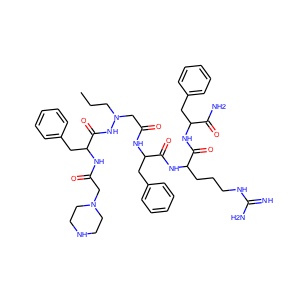
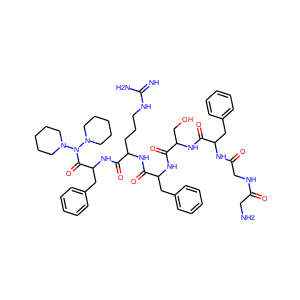
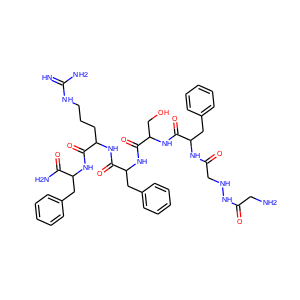
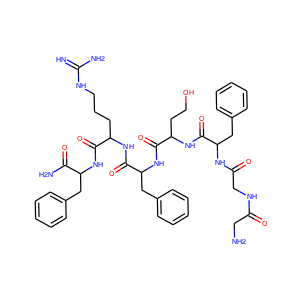
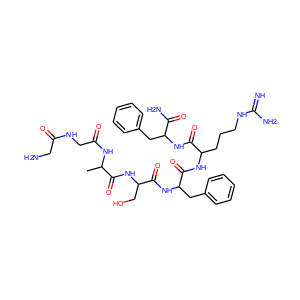
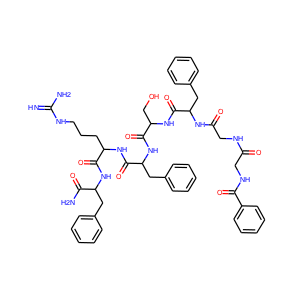
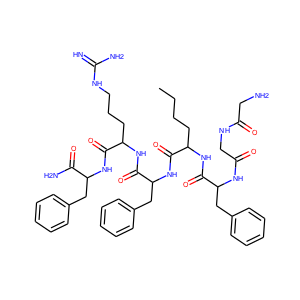
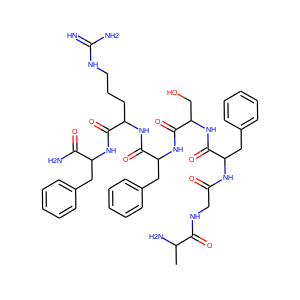
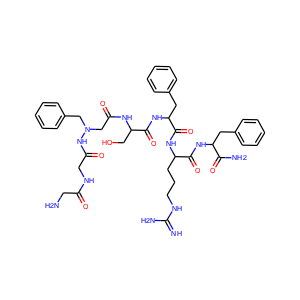
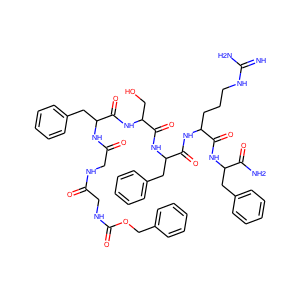
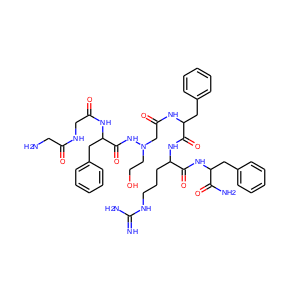
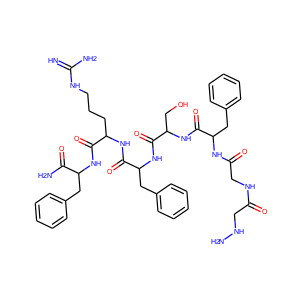
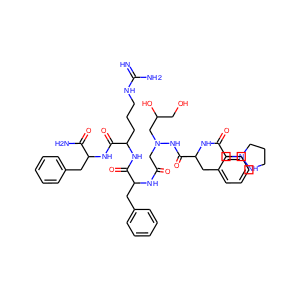
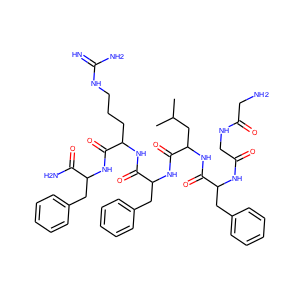
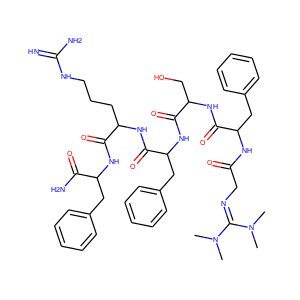
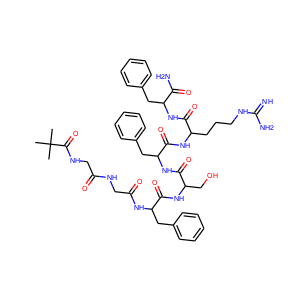
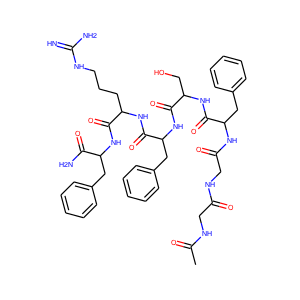

In [18]:
show_sample(df.query("symbol == 'QRFPR' and nat > 50"))

### QRFPR

Shows clearly bimodal size distribution.

symbol     amw  nat                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
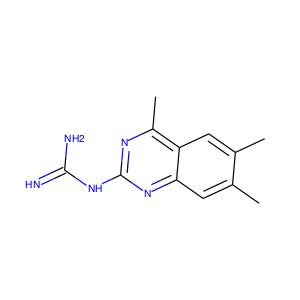
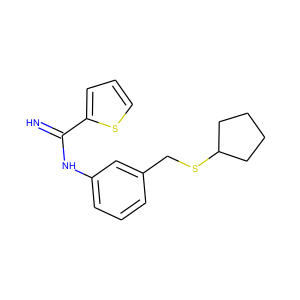
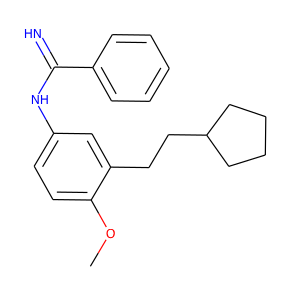
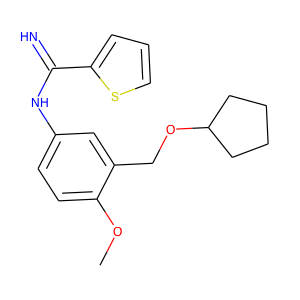
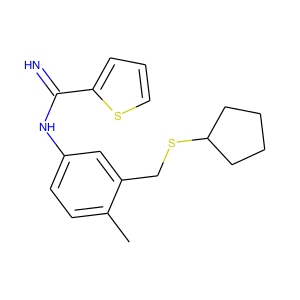
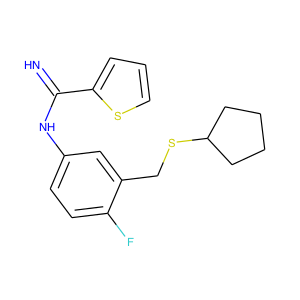
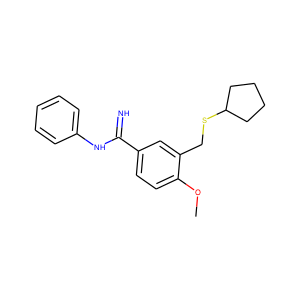
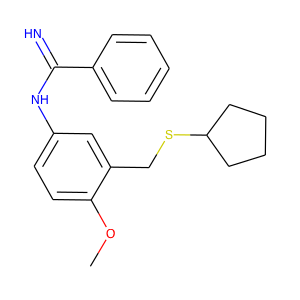
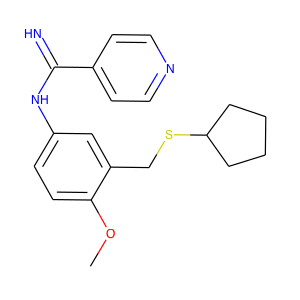
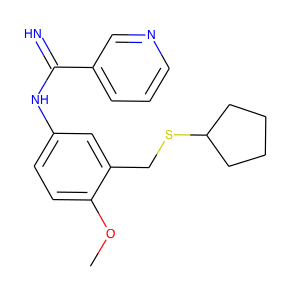
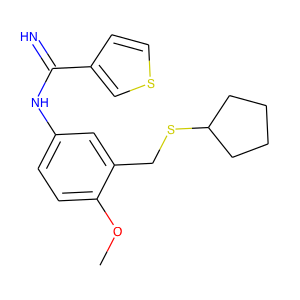
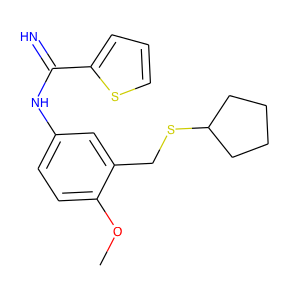
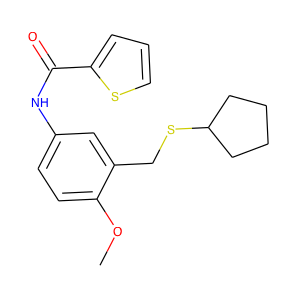
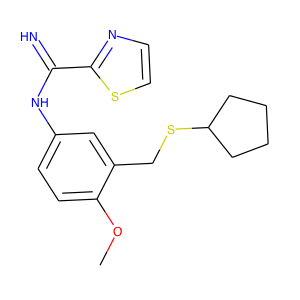
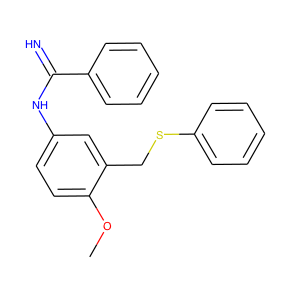
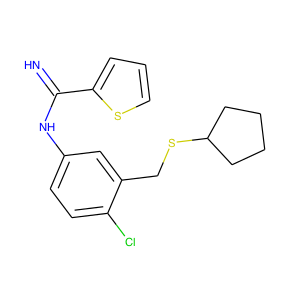
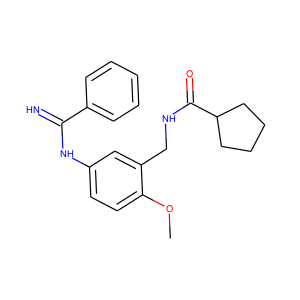
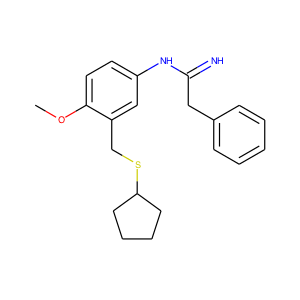
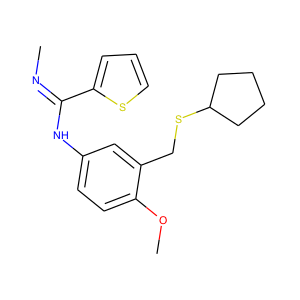
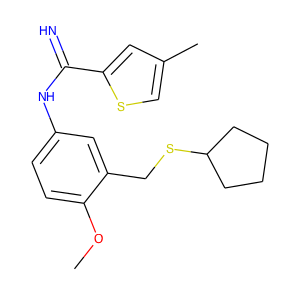
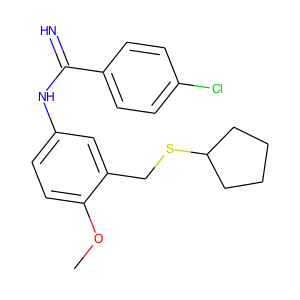
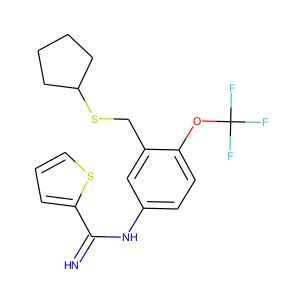
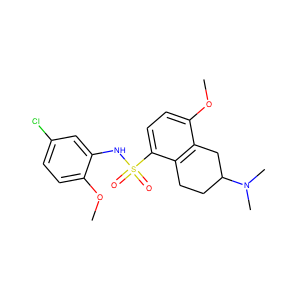
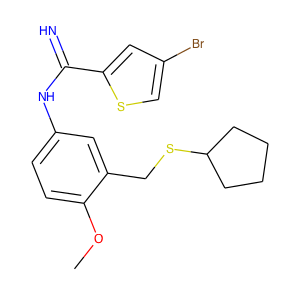
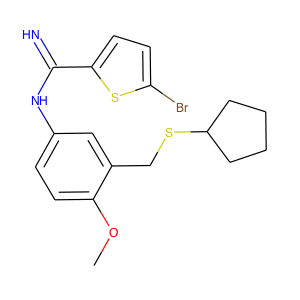
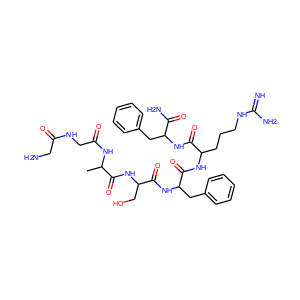
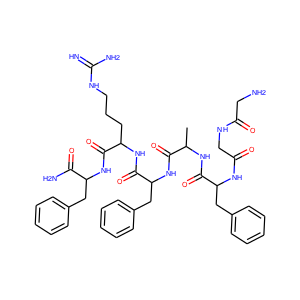
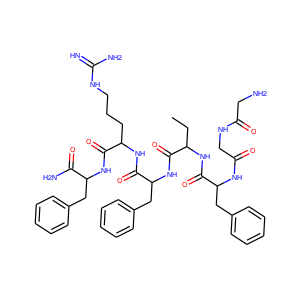
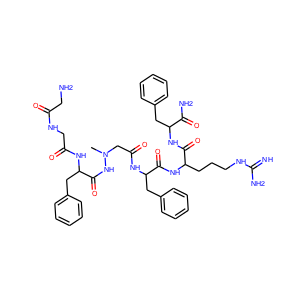
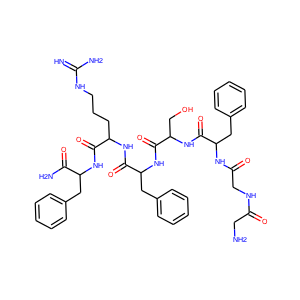
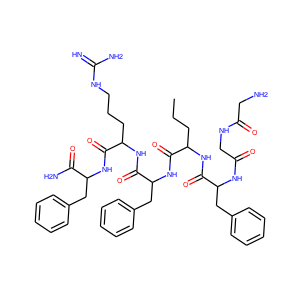
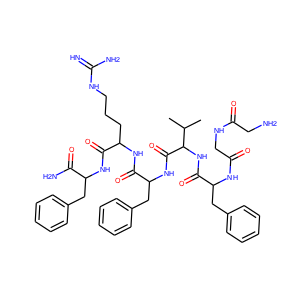
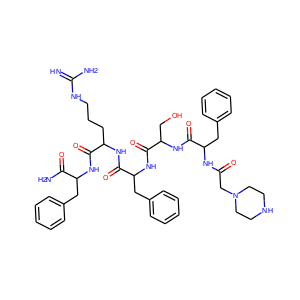
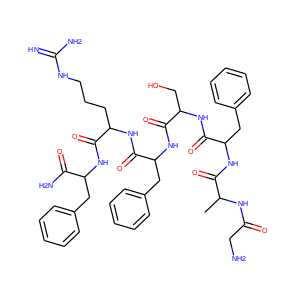
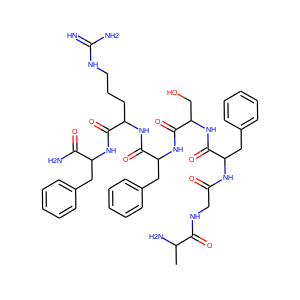
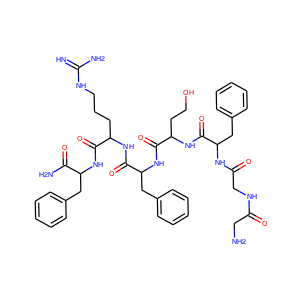
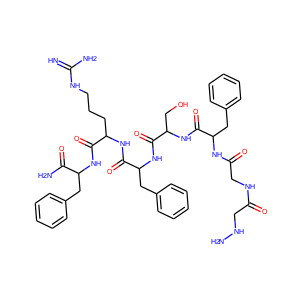
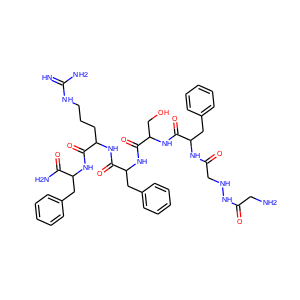
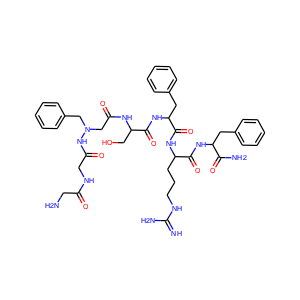
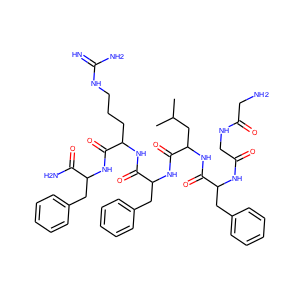
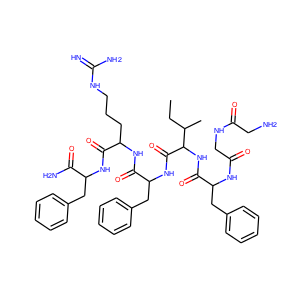
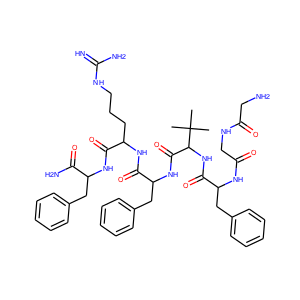
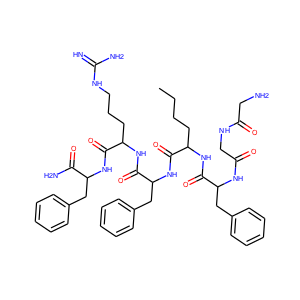
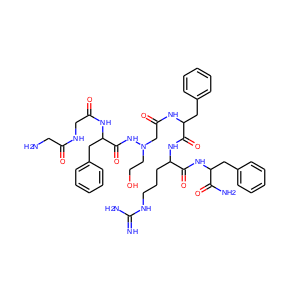
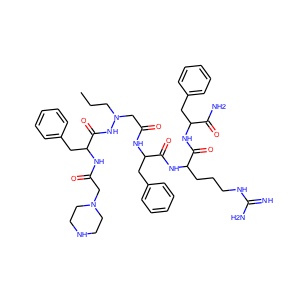
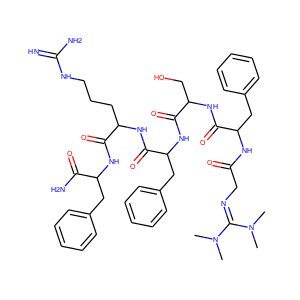
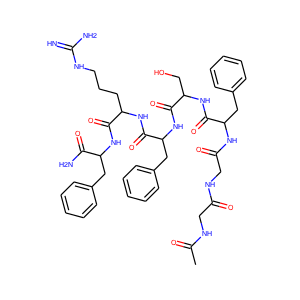
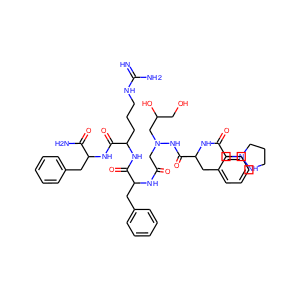
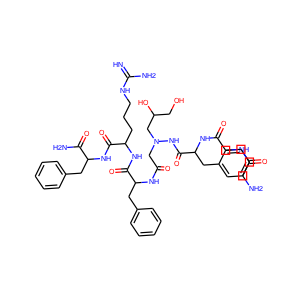
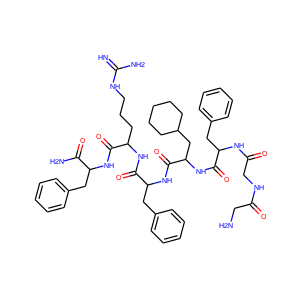
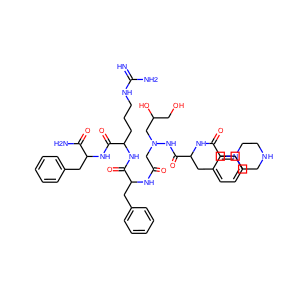
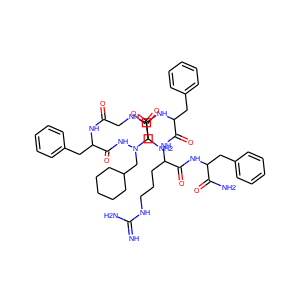
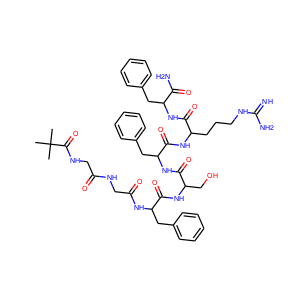
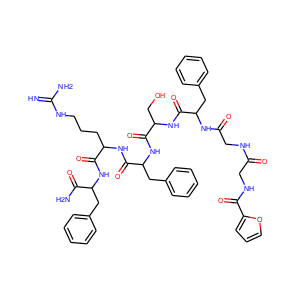
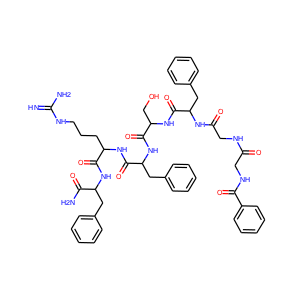
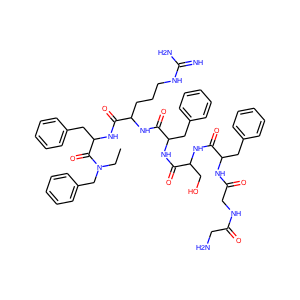
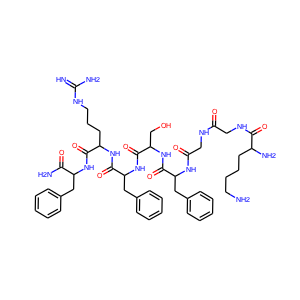
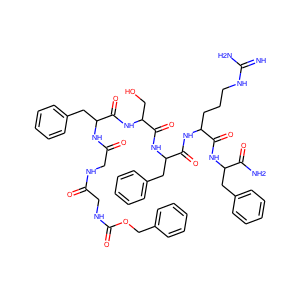
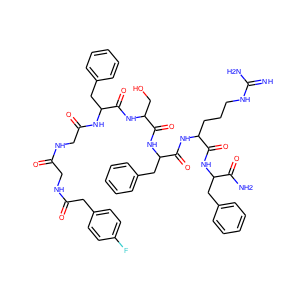
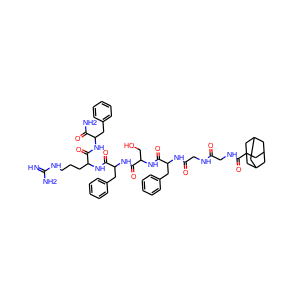
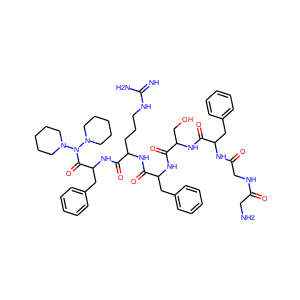

In [19]:
tmp = df.query("symbol == 'QRFPR'").sort('amw')

PandasTools.AddMoleculeColumnToFrame(tmp, smilesCol='usmiles', molCol='mol')

tmp.drop('usmiles', axis=1)